In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# Define data loaders
from torch.utils.data import DataLoader, random_split

# Define preprocessing transformations
import os

In [2]:
# Define the root directory for data
data_root = './data'

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

# Check if MNIST dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'MNIST')):
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
else:
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform)

# Check if CIFAR-10 dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'CIFAR10')):
    cifar_trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
    cifar_testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)
else:
    cifar_trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform)
    cifar_testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1 input channel, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)  # 32 input channels, 32 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  # 32 input channels, 64 output channels, 3x3 kernel
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)  # 64 input channels, 64 output channels, 3x3 kernel
        
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling with stride 2
        
        # Define global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        
        # Define fully connected layer
        self.fc = nn.Linear(64, 10)  # 64 input features, 10 output classes

    def forward(self, x):
        # Apply convolution and ReLU activation
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        # Apply max pooling
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        # Apply global average pooling
        x = self.global_pool(x)
        # Flatten for fully connected layer
        x = x.view(-1, 64)
        # Fully connected layer
        x = self.fc(x)
        return x

In [4]:
# ResNet50 architecture for CIFAR-10
class CIFAR_ResNet(nn.Module):
    def __init__(self):
        super(CIFAR_ResNet, self).__init__()
        self.resnet50 = resnet50(num_classes=10)

    def forward(self, x):
        return self.resnet50(x)

In [12]:
# Initialize models and optimizer
mnist_model = MNIST_CNN()
cifar_model = CIFAR_ResNet()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
cifar_optimizer = optim.Adam(cifar_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # multiclassification

# Define the size of the validation set (10% of the training set)
validation_size_mnist = int(0.1 * len(mnist_trainset))
# Split the training set into training and validation sets
mnist_trainset, mnist_valset = random_split(mnist_trainset, [len(mnist_trainset) - validation_size_mnist, validation_size_mnist])

# Define data loaders for training, validation, and testing
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_valloader = DataLoader(mnist_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

# Define the size of the validation set (10% of the training set)
validation_size_cifar = int(0.1 * len(cifar_trainset))

# Split the training set into training and validation sets
cifar_trainset, cifar_valset = random_split(cifar_trainset, [len(cifar_trainset) - validation_size_cifar, validation_size_cifar])

# Define data loaders for training, validation, and testing
cifar_trainloader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
cifar_valloader = DataLoader(cifar_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
cifar_testloader = DataLoader(cifar_testset, batch_size=64, shuffle=False)

In [13]:
def train_with_early_stopping(trainloader, valloader, testloader, model, optimizer, criterion, patience=5):
    best_val_accuracy = 0
    no_improvement_counter = 0

    for epoch in range(100):  # Maximum of 100 epochs
        # Train the model
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for inputs, labels in valloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1) # torch.max returns both the maximum values and their indices
                val_predictions.extend(predicted.numpy())
                val_true_labels.extend(labels.numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_accuracy}")

        # Check for improvement in validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    # Evaluate on the test set after training
    model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for inputs, labels in testloader: # batch wise for loop. 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.numpy())
            test_true_labels.extend(labels.numpy())

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy}")

    return test_accuracy


In [16]:
def create_failure_set(testloader, model):
    
    # Evaluate on the test set after training
    model.eval()
    test_predictions = []
    test_true_labels = []
    failure_set = []

    with torch.no_grad():
        for inputs, labels in testloader: # batch wise for loop. 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            misclassified_mask = predicted != labels
            failure_set.extend(inputs[misclassified_mask])

    # Calculate accuracy on the test set
    # test_accuracy = accuracy_score(test_true_labels, test_predictions)
    # print(f"Test Accuracy: {test_accuracy}")
    print("The size of the failure set is ", len(failure_set))
    return failure_set

In [14]:
mnist_test_accuracy = train_with_early_stopping(mnist_trainloader, mnist_valloader, mnist_testloader, mnist_model, mnist_optimizer, criterion)


Epoch 1: Validation Accuracy: 0.9368333333333333
Epoch 2: Validation Accuracy: 0.9611666666666666
Epoch 3: Validation Accuracy: 0.9693333333333334
Epoch 4: Validation Accuracy: 0.979
Epoch 5: Validation Accuracy: 0.9818333333333333
Epoch 6: Validation Accuracy: 0.985
Epoch 7: Validation Accuracy: 0.9836666666666667
Epoch 8: Validation Accuracy: 0.9885
Epoch 9: Validation Accuracy: 0.9888333333333333
Epoch 10: Validation Accuracy: 0.9896666666666667
Epoch 11: Validation Accuracy: 0.9891666666666666
Epoch 12: Validation Accuracy: 0.9905
Epoch 13: Validation Accuracy: 0.9915
Epoch 14: Validation Accuracy: 0.9921666666666666
Epoch 15: Validation Accuracy: 0.993
Epoch 16: Validation Accuracy: 0.9915
Epoch 17: Validation Accuracy: 0.9918333333333333
Epoch 18: Validation Accuracy: 0.99
Epoch 19: Validation Accuracy: 0.9905
Epoch 20: Validation Accuracy: 0.9911666666666666
No improvement for 5 epochs. Early stopping...
Test Accuracy: 0.9896


In [19]:
cifar_test_accuracy = train_with_early_stopping(cifar_trainloader, cifar_valloader, cifar_testloader, cifar_model, cifar_optimizer, criterion)

Epoch 1: Validation Accuracy: 0.4446
Epoch 2: Validation Accuracy: 0.4184
Epoch 3: Validation Accuracy: 0.5228
Epoch 4: Validation Accuracy: 0.4504
Epoch 5: Validation Accuracy: 0.5628
Epoch 6: Validation Accuracy: 0.571
Epoch 7: Validation Accuracy: 0.6116
Epoch 8: Validation Accuracy: 0.3908
Epoch 9: Validation Accuracy: 0.6526
Epoch 10: Validation Accuracy: 0.593
Epoch 11: Validation Accuracy: 0.6106
Epoch 12: Validation Accuracy: 0.6794
Epoch 13: Validation Accuracy: 0.5748
Epoch 14: Validation Accuracy: 0.6128
Epoch 15: Validation Accuracy: 0.6446
Epoch 16: Validation Accuracy: 0.7144
Epoch 17: Validation Accuracy: 0.7182
Epoch 18: Validation Accuracy: 0.7452
Epoch 19: Validation Accuracy: 0.7242
Epoch 20: Validation Accuracy: 0.7488
Epoch 21: Validation Accuracy: 0.7404
Epoch 22: Validation Accuracy: 0.7482
Epoch 23: Validation Accuracy: 0.7412
Epoch 24: Validation Accuracy: 0.7502
Epoch 25: Validation Accuracy: 0.7514
Epoch 26: Validation Accuracy: 0.7414
Epoch 27: Validation Ac

KeyboardInterrupt: 

The model fofr CIFAR is training very slowly, is very large(due to size of resnet) and is not getting very high accuracy. Seems to be stuck at 75%. Don't know the issue

F is the failure set denoting the examples on which there is wrong prediction

In [18]:
F_mnist= create_failure_set(mnist_testloader, mnist_model)

Test Accuracy: nan
The size of the failure set is  104


/Users/tejasr/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/tejasr/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
torch.save(mnist_model.state_dict(), 'mnist_model.pth')
torch.save(cifar_model.state_dict(), 'cifar_model.pth')

## Identifying failure causes: 
1) Annotation noise<br>
2) Random Input noise <br>
3) Adversarial poisoning<br>

1) Adding label noise to the dataset: first defining the confusion matrices as defined in the paper for both mnist and cifar10.

In [34]:
# Assuming you have the confusion matrix defined as confusion_matrix
# MNIST confusion matrix
# Initialize a 10x10 confusion matrix with ones on the diagonal
mnist_cm = np.eye(10)
# Set misclassification probabilities
mnist_cm[1, 1] = 0.6 
mnist_cm[7, 7] = 0.6  
mnist_cm[1, 7] = 0.4  # Probability of misclassifying label 1 as label 7
mnist_cm[7, 1] = 0.4  # Probability of misclassifying label 7 as label 1
mnist_cm[6, 6] = 0.7  
mnist_cm[9, 9] = 0.7  
mnist_cm[6, 9] = 0.3  # Probability of misclassifying label 6 as label 9
mnist_cm[9, 6] = 0.3  # Probability of misclassifying label 9 as label 6
print(mnist_cm)

[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.3]
 [0.  0.4 0.  0.  0.  0.  0.  0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.7]]


In [37]:
# List of label names
label_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Create a dictionary mapping label names to numerical labels starting from 0
label_map = {label_names[i]: i for i in range(len(label_names))}
# Assuming you have the confusion matrix defined as confusion_matrix
# CIFAR-10 confusion matrix
# Initialize a 10x10 confusion matrix with ones on the diagonal
cifar_cm = np.eye(10)
# Set misclassification probabilities
cifar_cm[label_map['plane'], label_map['plane']] = 0.6
cifar_cm[label_map['bird'], label_map['bird']] = 0.6 
cifar_cm[label_map['plane'], label_map['bird']] = 0.4 # Probability of misclassifying airplane as bird
cifar_cm[label_map['bird'], label_map['plane']] = 0.4 # Probability of misclassifying bird as airplane 
cifar_cm[label_map['cat'], label_map['cat']] = 0.7
cifar_cm[label_map['dog'], label_map['dog']] = 0.7
cifar_cm[label_map['cat'], label_map['dog']] = 0.3
cifar_cm[label_map['dog'], label_map['cat']] = 0.3 # check these once, the paper gives a contradictory cm. 
# print(cifar_cm)
# Print label names along with the confusion matrix
print('\t' + '\t'.join(label_names))
for i in range(len(label_names)):
    print(label_names[i], '\t', end='')
    print('\t'.join(str(cifar_cm[i, j]) for j in range(len(label_names))))


	plane	car	bird	cat	deer	dog	frog	horse	ship	truck
plane 	0.6	0.0	0.4	0.0	0.0	0.0	0.0	0.0	0.0	0.0
car 	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
bird 	0.4	0.0	0.6	0.0	0.0	0.0	0.0	0.0	0.0	0.0
cat 	0.0	0.0	0.0	0.7	0.0	0.3	0.0	0.0	0.0	0.0
deer 	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0
dog 	0.0	0.0	0.0	0.3	0.0	0.7	0.0	0.0	0.0	0.0
frog 	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0
horse 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0
ship 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0
truck 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0


In [50]:
def flip_labels(dataloader, cm):
    noisy_labels = []
    misclassifcn_dict= {i: 0 for i in range(10)}
    for _, labels in dataloader:
        for label in labels:
            # Randomly flip the label according to the confusion matrix
            noisy_label = np.random.choice(np.arange(len(cm)), p=cm[label])
            if(noisy_label!=label):
                # print(label.shape, label)
                misclassifcn_dict[int(label.numpy())]+=1 # label is a tensor so conversion is needed to access dict keys
            noisy_labels.append(noisy_label)
						
    return noisy_labels, misclassifcn_dict

# Apply noise to the training labels
noisy_mnist_labels, missclassfcn_dict = flip_labels(mnist_testloader, mnist_cm)
# using these noisy labels will be equivalent to adding annotation noise
print(len(noisy_mnist_labels))
print(missclassfcn_dict)

10000
{0: 0, 1: 451, 2: 0, 3: 0, 4: 0, 5: 0, 6: 309, 7: 406, 8: 0, 9: 335}


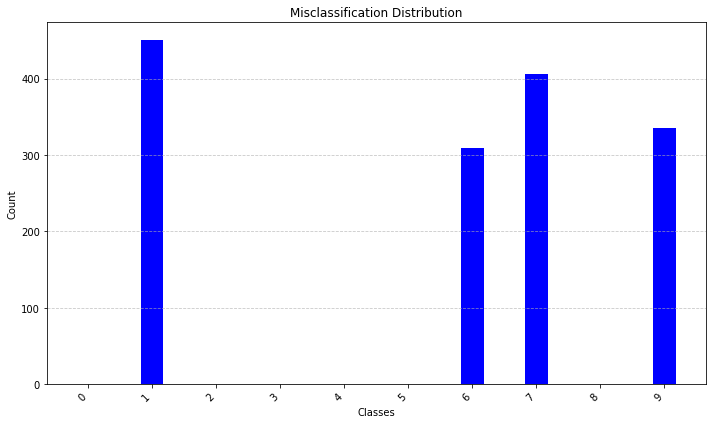

In [58]:
def plot_histogram(misclassfcn_dict, label_names=None):
    if label_names is None:
        label_names = [str(i) for i in range(10)]
    plt.figure(figsize=(10, 6))
    bins = np.arange(len(label_names) + 1)  # Define bin edges
    width = 0.35  # Width of each bar
    for idx, (label, freq) in enumerate(misclassfcn_dict.items()):
        plt.bar(idx, freq, width, label=label_names[label], color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Misclassification Distribution')
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
    # plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot histogram
plot_histogram(misclassfcn_dict=missclassfcn_dict)


This corresponds with the MNIST one given. But why is the count for 1 so low in the paper? Also, why are the other numbers non zero in the paper? Do we have to introduce a non zero noise for all the classes? 

In [33]:
print(len(mnist_trainloader)*64, len(mnist_testloader)*64, len(mnist_valloader)*64)
# 10% of training set(6000) is used for validation, leaving 54k in the training set of mnist. 

54016 10048 6016


In [73]:
# Define the root directory for data
data_root = './data'
# Define preprocessing transformations
transform1 = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

mnist_trainset1 = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform1)
mnist_testset1 = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform1)

cifar_trainset1 = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform1)
cifar_testset1 = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform1)

2) Random input noise

Original (Label: 1) | Noisy (Label: 1)


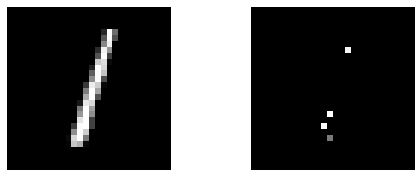

Original (Label: 7) | Noisy (Label: 7)


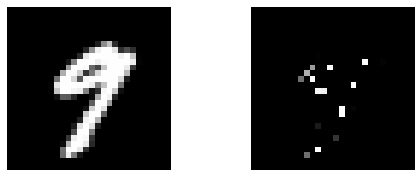

Original (Label: 1) | Noisy (Label: 1)


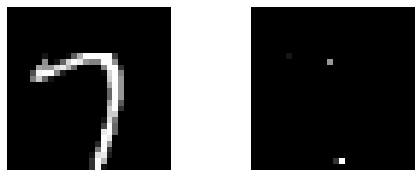

In [86]:
# inages of both the datasets are constrained between 0 and 1, with 0 meaning black. 
def input_noise(dataset, classes, gamma=0.3, mode="Gaussian", num_examples=2):
    assert mode in ["Salt and Pepper", "Gaussian"], "Mode must be either 'Salt and Pepper' or 'Gaussian'"
    assert 0 <= gamma <= 1, "Gamma must be in the range [0, 1]"
    
    noisy_images = []
    bar = 0
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label in classes:
                temp = image.clone()  # Create a copy of the image tensor
                noisy_image = None
                if np.random.rand() < gamma:  # Apply noise with probability gamma
                    if mode == "Salt and Pepper":
                        noisy_image = add_salt_and_pepper_noise(temp)
                    elif mode == "Gaussian":
                        noisy_image = add_gaussian_noise(temp)
                    
                    if bar < num_examples:
                        # Print the original and noisy images for a few examples
                        print("Original (Label: {}) | Noisy (Label: {})".format(labels[idx], labels[idx]))
                        show_images_in_one_row(temp, noisy_image)
                        bar += 1
                else:
                    noisy_image = temp
        else:
                temp = image
                noisy_image = temp
                
        noisy_images.append(noisy_image)
    return noisy_images

def add_salt_and_pepper_noise(image):
    # print(image)
    noisy_image = image.clone()
    mask = torch.rand_like(image) < 0.9 # Salt and pepper noise with equal probability
    # mask1 = !mask  # Salt and pepper noise with equal probability
    noisy_image[mask] = 0
    # noisy_image[~mask]+= 
    # mask = torch.rand_like(image) < 0.5
    # noisy_image[mask] = 255
    return noisy_image

def add_gaussian_noise(image):
    noisy_image = image.clone()
    noise = torch.randn_like(image) # Standard deviation of 25 for Gaussian noise
    noisy_image += noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

def show_images_in_one_row(image1, image2):
    plt.figure(figsize=(8, 3))
    if image1.shape[0] == 3:  # RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.permute(1, 2, 0))  # Permute to move channel dimension to the last
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.permute(1, 2, 0))
        plt.axis('off')
    else:  # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

noisy_images = input_noise(mnist_testset1, [1, 7, 6, 9], gamma=0.3, mode="Salt and Pepper", num_examples=3)



Original (Label: 4) | Noisy (Label: 4)


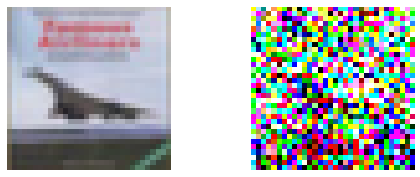

Original (Label: 5) | Noisy (Label: 5)


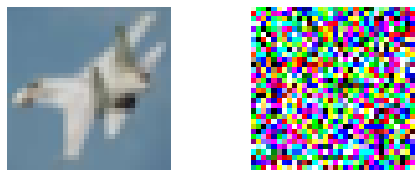

Original (Label: 5) | Noisy (Label: 5)


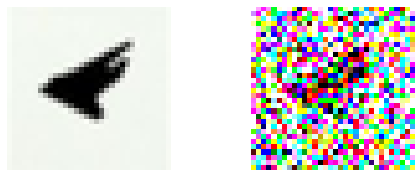

In [88]:
noisy_images = input_noise(cifar_testset1, [0, 2, 3, 5], gamma=0.3, mode="Gaussian", num_examples=3)